In [ ]:
---
title: "Introduction to Quantum Singular Value Transformation"
description: "Or grand unification of quantum algorithms, if you feel a bit grandiose."
aliases:
  - quantum_singular_value_transformation_intro.html
bibliography: references.bib
csl: physical-review-letters.csl
toc: true
image: what_to_use_qc_for.svg
date: '2023-05-15'

format:
  html:
    html-math-method: mathjax
    include-in-header:
      - text: |
          <script>
          window.MathJax = {
            tex: {
              tags: 'ams'
            }
          };
          </script>
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from functools import reduce

import pyqsp
import pyqsp.angle_sequence
import pyqsp.response

from pyqsp.angle_sequence import QuantumSignalProcessingPhases

# Quantum signal processing

Define the basic setup of quantum signal processing.
- Implementing arbitrary polynomials subject to conditions.
- Measure in $|\pm\rangle$ basis.
- Automated way to find phases.

In [11]:
def R(a):
    """Singla operator in R-convention"""
    
    b = np.sqrt(1-a**2)
    W = np.array([
        [a, b],
        [b, -a]])

    return W

def Sz(phi):
    return np.diag([np.exp(1j*phi), np.exp(-1j*phi)])

def angles_from_Wx_to_R(phis):
    assert len(phis)>0, 'At least one angle must be provided.'
    phis = \
    [phis[0]+(2*len(phis)-3)*np.pi/4] \
    + [phi-np.pi/2 for phi in phis[1:-1]] \
    + [phis[-1]-np.pi/4]
    
    return phis 

def apply_QSP(w, phis):
    """Computes S(phi_0) @ w @ s(phi_1) @ w ... @ S(phi_d-1) @ w @ S(phi_d)."""
    
    phis = angles_from_Wx_to_R(phis)
    
    res = Sz(phis[-1])
    for phi in phis[:-1][::-1]:        
        res = Sz(phi) @ w @ res
    
    return res

Exercise: implement polynomial by phases.

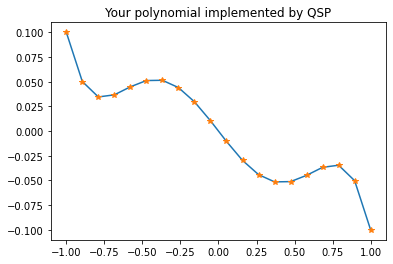

In [17]:
# An excersize.

def polynomial_value(coeffs, x):
    """ Computes c[0]*x**0 + c[1]*x**1+...+c[n]*x**n. """
    x = np.array([x])
    return (np.array(coeffs) * x**np.arange(len(coeffs))).sum()

# Som arbitrary set of polynomial coefficiets.
# Must define even or odd polynomial p(x) that satisfies p(x)<1 for -1<x<1. 

coeffs =  [0., -0.2, 0., 0.5, 0., -0.4]
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')

# Compute polynomial values in the range [-1, 1] directly
x = np.linspace(-1, 1, 20)
poly_values = [polynomial_value(coeffs, xi) for xi in x]

# Compute matrix elements of the QSP sequence
unitaries = [apply_QSP(R(xi), phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Verify they agree.
# assert np.allclose(poly_values, matrix_elements, atol=1e-5)
plt.plot(x, poly_values);
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

# QSVT

- Block embedding in the computational basis
$$U=\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}$$
- For a single-qubit embedding $U=|0\rangle \langle0|\otimes A+\dots$.
- More generally, there is some basis change $B_L, B_R$ that leads to the standard block-encoding
$$U=B_L\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}B_R$$
With any such basis we associated projectors $\Pi_L=B_L\left(|0\rangle\langle0|\otimes \mathbb{1} \right)B_L^\dagger $ which satisfy
$$\Pi_L U \Pi_R = B_L\begin{pmatrix}A&0\\0&0\end{pmatrix}B_R$$
- We need access to 
$$\Pi_L(\phi)=e^{(2\Pi_L-\mathbb{I})\phi}=B_L \begin{pmatrix}e^{i\phi}&0\\ 0&e^{-i\phi}\end{pmatrix}B_L^\dagger$$

Then, the main statement of QSVT is the following. A bit awkwardly, it needs to be split in two cases. First consider when the polynomial is even (the number of phases is odd)

$$U_{\phi}=\prod_{i=0}^{d/2-1}\Pi_R(\phi_{2i})U^\dagger\Pi_L(\phi_{2i+1})U$$
When the polynomial is odd (the number of phases even)

$$U_{\phi}=\Pi_L(\phi_{0})U\prod_{i=1}^{(d-1)/2}\Pi_R(\phi_{2i-1})U^\dagger\Pi_L(\phi_{2i})U$$

In [ ]:
def apply_QSVT(U, PL, PR, phis):
    
    phi_last = phis[-1]
    
    if len(phis) % 2 == 1: # Even polynomial
        phis_paired = phis[:-1]
        phi_0 = None
    else: # Odd polynomial
        phis_paired = phis[1:-1]
        phi_0 = phis[0]
    
    res = projector_rotation(PR, phi_last)
    
    for phi_R, phi_L in np.array(phis_paired).reshape(-1, 2)[::-1]:
        res =  projector_rotation(PR, phi_R) @ U.conj().T @  projector_rotation(PL, phi_L) @ U @ res
    
    if phi_0 is not None:
        res = projector_rotation(PL, phi_0) @ U @ res
        
    return res

# Amplitude amplification

Encompasses
1. Grover's search.
1. Oblivious amplitude amplification.
1. Used in other quantum algorithms.

## Test

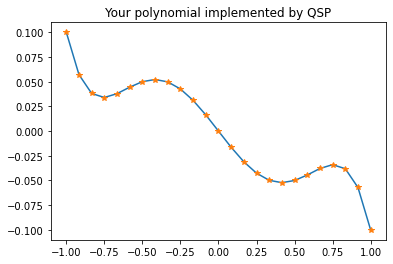

In [27]:
P = np.diag([1, 0])


coeffs =  [0, -0.2, 0., 0.5, 0., -0.4]
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
phis = angles_from_Wx_to_R(phis)

# Compute polynomial values in the range [-1, 1] directly
x = np.linspace(-1, 1, 25)
poly_values = [polynomial_value(coeffs, xi) for xi in x]

unitaries =[apply_QSVT(R(xi), P, P, phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Verify they agree.
# assert np.allclose(poly_values, matrix_elements, atol=1e-5)
plt.plot(x, poly_values);
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

## Poly test

In [173]:
target_function = pyqsp.poly.PolySign()

coeffs_list = []
vals = []
for N in range(100)[::1]:
    degree = np.ceil(np.sqrt(N))
    if degree % 2 == 0:
        degree += 1
        
    coeffs, scale = target_function.generate(degree, delta=2*np.sqrt(N), ensure_bounded=True, return_scale=True);
    coeffs_list.append(coeffs)
    vals.append(polynomial_value(coeffs, 1/np.sqrt(N)))

[pyqsp.poly.PolySign] degree=1, delta=0.0
[PolyTaylorSeries] max [inf] is at [0.1]: normalizing
[PolyTaylorSeries] average error = nan in the domain [-1, 1] using degree 1
[pyqsp.poly.PolySign] degree=1, delta=2.0
[PolyTaylorSeries] max [0.90422975] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.26665743286212396 in the domain [-1, 1] using degree 1
[pyqsp.poly.PolySign] degree=3, delta=2.8284271247461903
[PolyTaylorSeries] max [0.86327883] is at [0.86147542]: normalizing
[PolyTaylorSeries] average error = 0.19244082131510504 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=3.4641016151377544
[PolyTaylorSeries] max [0.86108651] is at [0.85815461]: normalizing
[PolyTaylorSeries] average error = 0.22773801483727588 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=4.0
[PolyTaylorSeries] max [0.86083901] is at [0.85777936]: normalizing
[PolyTaylorSeries] average error = 0.24924335463420821 in the domain [-1, 1] using degree 

<ipython-input-173-f78e201399c8>:12: RuntimeWarning: divide by zero encountered in double_scalars
  vals.append(polynomial_value(coeffs, 1/np.sqrt(N)))


[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.16776128430658827 in the domain [-1, 1] using degree 9
[pyqsp.poly.PolySign] degree=9, delta=14.696938456699069
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.16812077831752725 in the domain [-1, 1] using degree 9
[pyqsp.poly.PolySign] degree=9, delta=14.832396974191326
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.16847047156515008 in the domain [-1, 1] using degree 9
[pyqsp.poly.PolySign] degree=9, delta=14.966629547095765
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.16881080315595778 in the domain [-1, 1] using degree 9
[pyqsp.poly.PolySign] degree=9, delta=15.0996688705415
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.16914218512505289 in the domain [-1, 1] using degree 9
[pyqsp.poly.PolySign] degree=9, delta=15.23154621

## Implementation

In [162]:
def f():
    print('Fuck @Vitalikm')
    return True

In [161]:
np.random.seed(42)


def projector_rotation(P, phi):
    n = len(P)
    return np.eye(n)*np.cos(phi)-1j*(2*P-np.eye(n))*np.sin(phi)

def projector_from_state(state):
    return np.outer(state, state.conj())


amplitudes = []
for num_qubits in range(1, 11):
    
    N = 2**num_qubits
    
    # Define initial state |0> and the associated projector.
    all_zero_state = np.zeros(N)
    all_zero_state[0] = 1
    PR = projector_from_state(all_zero_state)

    # Define a random marked state. It will only be accessed via the corresponding projector.
    marked_state = np.zeros(N)
    marked_state[np.random.randint(0, N)] = 1
    PL = projector_from_state(marked_state)

    # Signal operator is the n-th tensor power of the Hadamard gate.
    H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
    U = reduce(np.kron, [H]*num_qubits)

    
    target_function = pyqsp.poly.PolySign()
    
    degree = np.ceil(N**0.5)
    if degree % 2 == 0:
        degree += 1
    
    delta = N**0.5
    coeffs, _ =  target_function.generate(degree, delta=delta, return_scale=True)
    _ =  target_function.generate(degree, delta=delta, return_scale=True)

#     phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
#     phis = angles_from_Wx_to_R(phis)

#     U_phi = apply_QSVT(U, PL, PR, phis)
#     amplitude = np.max(np.abs(np.real(PL @ U_phi @ PR)))
    
#     amplitudes.append(amplitude)

[pyqsp.poly.PolySign] degree=3, delta=1.4142135623730951
[PolyTaylorSeries] max [0.9429023] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.04777167328141418 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=1.4142135623730951
[PolyTaylorSeries] max [0.9429023] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.04777167328141418 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=2.0
[PolyTaylorSeries] max [0.88487764] is at [0.89510929]: normalizing
[PolyTaylorSeries] average error = 0.12112171443398506 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=2.0
[PolyTaylorSeries] max [0.88487764] is at [0.89510929]: normalizing
[PolyTaylorSeries] average error = 0.12112171443398506 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=2.8284271247461903
[PolyTaylorSeries] max [0.86327883] is at [0.86147542]: normalizing
[PolyTaylorSeries] average error = 0.19244082131510504 

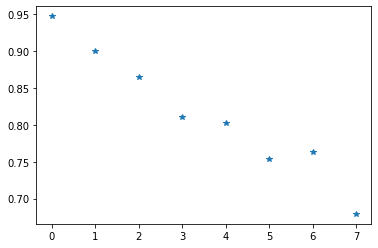

In [158]:
plt.plot(amplitudes, '*')

# Hamiltonian simulation

We are given three things

1. Block embedding of a Hamiltonian $H$, i.e. $U$ s.t. $H=\left(\langle 0|\otimes I \right)U\left(|0\rangle\otimes I\right)$.
2. Projectors $\Pi(\phi)$.
3. ??


## Block encodings

Singular value $\sigma$ are positive square roots of eigenvalues $M^\dagger M\ge0$.

To block encode some matrix $M$ we need $||M||\le1$ where $||\cdot||$ is the operator norm or, equivalently, the largest singular value.

In [216]:
class BlockEncoding:
    
    def __init__(self, M):
        
        self.num_rows = M.shape[0]
        self.num_cols = M.shape[1]
        self.dim = 2*max(self.num_rows, self.num_cols)
        
        self.diagonal_block = self.pad_matrix_to_square(M)
        
        U, S, WH = np.linalg.svd(self.diagonal_block)
        
        self.U = U
        self.S = S
        self.WH = WH
        
        self.off_diagonal_block = self.make_off_diagonal_block(self.U, self.S, self.WH)
        
        self.unitary = self.unitary_from_blocks(
            self.diagonal_block, 
            self.off_diagonal_block)
                    
    @staticmethod
    def pad_matrix_to_square(M):
        """Pads a matrix with zeros to make it square."""

        n_rows, n_cols = M.shape
        n_max = max(n_rows, n_cols)
        S = np.zeros((n_max, n_max), dtype=np.complex64)
        S[:n_rows,:n_cols] = M
        return S
    
    @staticmethod
    def make_off_diagonal_block(u, s, wh):
        assert np.all(s<=1), f'All singular values {s} must be less than 1.'
        return u @ np.diag(np.sqrt(1-s**2)) @ wh
    
    @staticmethod
    def unitary_from_blocks(A, B):
        n = A.shape[0]
        U = np.zeros((2*n, 2*n), dtype=np.complex64)
        U[:n, :n] = A
        U[:n,n:2*n] = B
        U[n:2*n, :n] = B
        U[n:2*n, n:2*n] = -A
        
        assert np.allclose(U @ U.conj().T, np.eye(2*n), atol=1e-5), 'Ops, block encoding is not unitary.'
        return U

In [189]:
import contextlib
import io

f = io.StringIO()
with contextlib.redirect_stdout(f):
    costx = pyqsp.poly.PolyCosineTX()

    t = 12
    coeffs = costx.generate(tau=t, epsilon=0.1)

## Implementation

In [242]:
seed = 42
np.random.seed(seed)

num_qubits = 5
N = 2**num_qubits

V = scipy.stats.unitary_group.rvs(N, random_state=seed)
D = np.random.uniform(low=0, high=1, size=(N,))

H = V*D @ V.conj().T

block_encoding = BlockEncoding(H)
U = block_encoding.unitary

In [243]:
costx = pyqsp.poly.PolyCosineTX()

t = 2
coeffs = costx.generate(tau=t, epsilon=0.01)
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
phis = angles_from_Wx_to_R(phis)

P = np.kron(np.diag([1, 0]), np.eye(N))
U_phi = apply_QSVT(U, P, P, phis)

5.792289243194879
R=2
[PolyCosineTX] rescaling by 0.5.


In [244]:
np.linalg.eigvalsh(U_phi[:N,:N])

array([-0.18221681, -0.16709831, -0.08803831, -0.05479972, -0.00635646,
        0.05305195,  0.07777323,  0.16915992,  0.17158634,  0.17868893,
        0.18439762,  0.19089866,  0.24816006,  0.26010535,  0.30721112,
        0.32751157,  0.36432588,  0.37363752,  0.41209875,  0.41333768,
        0.42252727,  0.45291397,  0.45890119,  0.4641323 ,  0.46871851,
        0.47264311,  0.47739448,  0.48164932,  0.48646686,  0.49638498,
        0.5022454 ,  0.50547176])

In [245]:
0.5*np.sort(np.cos(D*t))

array([-1.80352364e-01, -1.62320566e-01, -8.04270520e-02, -4.69750961e-02,
        2.22201997e-04,  5.33027399e-02,  7.70177215e-02,  1.70081645e-01,
        1.74126420e-01,  1.80139193e-01,  1.82428569e-01,  1.88227675e-01,
        2.48996771e-01,  2.58065436e-01,  3.06027416e-01,  3.24742252e-01,
        3.66157752e-01,  3.71677648e-01,  4.10257632e-01,  4.17052163e-01,
        4.17556464e-01,  4.55585681e-01,  4.60657434e-01,  4.66738252e-01,
        4.67302407e-01,  4.71202285e-01,  4.75855052e-01,  4.75862456e-01,
        4.80667347e-01,  4.96630086e-01,  4.97843911e-01,  4.99576338e-01])

In [246]:
0.5*scipy.linalg.cosm(H*t)

array([[ 3.26328474e-01-2.77555756e-17j, -3.81939912e-02-3.19052465e-02j,
         2.35378147e-03-2.46012763e-02j, ...,
        -1.88216202e-02+2.29020750e-02j, -6.04615628e-02+5.62297927e-03j,
        -9.21175308e-03+1.94924097e-02j],
       [-3.81939912e-02+3.19052465e-02j,  2.69952426e-01-2.77555756e-17j,
         2.63173820e-03+6.58676484e-03j, ...,
         1.31601237e-02+2.30416099e-02j,  7.26064309e-05-3.08382740e-02j,
         3.07910348e-02+1.61953237e-02j],
       [ 2.35378147e-03+2.46012763e-02j,  2.63173820e-03-6.58676484e-03j,
         2.80504276e-01-2.77555756e-17j, ...,
         8.55499613e-03+9.77415406e-03j,  2.52277786e-03+3.13815972e-02j,
         3.63906469e-02-2.91179723e-02j],
       ...,
       [-1.88216202e-02-2.29020750e-02j,  1.31601237e-02-2.30416099e-02j,
         8.55499613e-03-9.77415406e-03j, ...,
         3.27476397e-01+2.77555756e-17j,  1.55543888e-02+2.12632738e-02j,
        -1.73093590e-02-2.96594387e-02j],
       [-6.04615628e-02-5.62297927e-03j,  7.

In [247]:
U_phi[:N,:N]

array([[ 0.32620272+8.93039461e-01j, -0.04320226-2.59124951e-02j,
        -0.00140168-2.48233874e-02j, ..., -0.01524238+2.55822346e-02j,
        -0.05917956+1.49638316e-02j, -0.00603753+2.09262920e-02j],
       [-0.03336594+3.79122553e-02j,  0.2698379 +9.01774284e-01j,
         0.00339559+6.10626675e-03j, ...,  0.0166833 +2.07714264e-02j,
        -0.00456972-3.09351352e-02j,  0.03337604+1.13372942e-02j],
       [ 0.00614107+2.40256276e-02j,  0.00158954-6.87691627e-03j,
         0.28033458+9.00180780e-01j, ...,  0.00997211+8.42760458e-03j,
         0.00727316+3.10687377e-02j,  0.03167703-3.48867515e-02j],
       ...,
       [-0.02213599-1.99262465e-02j,  0.00978936-2.48985712e-02j,
         0.00706697-1.10509079e-02j, ...,  0.32764554+8.92599385e-01j,
         0.0187824 +1.87226151e-02j, -0.02176365-2.68106953e-02j],
       [-0.06110978+3.41430510e-03j,  0.00502169+3.06718527e-02j,
        -0.00253245-3.15797717e-02j, ...,  0.0123289 -2.34919046e-02j,
         0.26546761+9.02356835e-01j

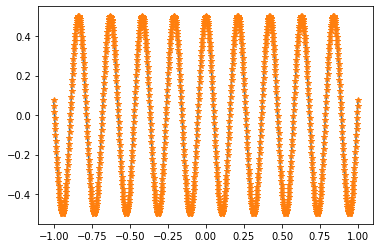

In [187]:
x = np.linspace(-1, 1, 1000)

poly_vals = [polynomial_value(coeffs, xi) for xi in x]
plt.plot(x, 0.5*np.cos(x*t))
plt.plot(x, poly_vals, '*')